In [1]:
import yfinance as yf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

solana_ticker = 'SOL-USD'
solana_data = yf.download(solana_ticker, start="2021-01-01", end="2023-12-31")

raydium_ticker = 'ORCA-USD'
raydium_data = yf.download(raydium_ticker, start="2021-01-01", end="2023-12-31")

solana_dex = pd.read_csv('chain-dataset-Solana.csv')

raydium_tvl = solana_dex[solana_dex['Protocol'] == 'Raydium'].drop(columns = ['Protocol']).T
raydium_tvl.index = pd.to_datetime(raydium_tvl.index, format='%d/%m/%Y')
raydium_tvl.rename(columns={1:'Total Value Locked'}, inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


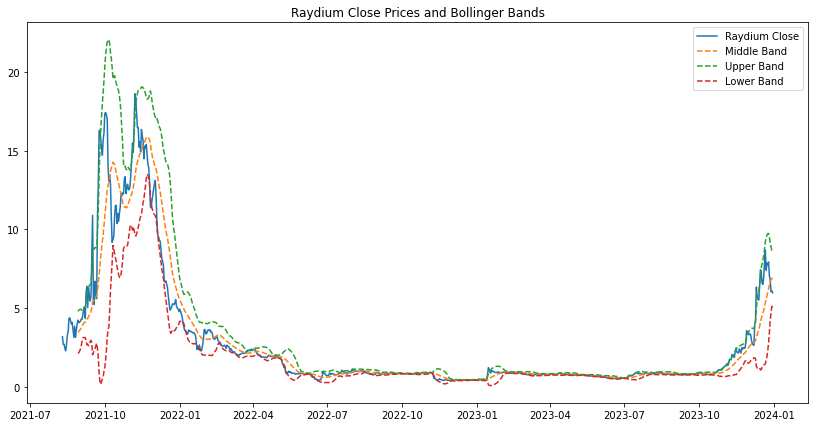

In [2]:
# Assuming raydium_data is already loaded
# Calculate Bollinger Bands
def calculate_bollinger_bands(df):
    period = 20  # 20-day SMA
    df['Middle Band'] = df['Close'].rolling(window=period).mean()
    df['STD'] = df['Close'].rolling(window=period).std()
    df['Upper Band'] = df['Middle Band'] + (df['STD'] * 2)
    df['Lower Band'] = df['Middle Band'] - (df['STD'] * 2)
    return df

raydium_data = calculate_bollinger_bands(raydium_data)

# Plot Raydium's closing prices and Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(raydium_data.index, raydium_data['Close'], label='Raydium Close')
plt.plot(raydium_data.index, raydium_data['Middle Band'], label='Middle Band', linestyle='--')
plt.plot(raydium_data.index, raydium_data['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(raydium_data.index, raydium_data['Lower Band'], label='Lower Band', linestyle='--')
plt.legend()
plt.title('Raydium Close Prices and Bollinger Bands')
plt.show()


In [3]:
# Initialize a list to temporarily store trade information
trades_list = []

# Iterate through Raydium data to find breakouts and trade closure points
in_trade = False
for i in range(len(raydium_data)):
    row = raydium_data.iloc[i]
    # Check for breakout
    if not in_trade and (row['Close'] > row['Upper Band'] or row['Close'] < row['Lower Band']):
        in_trade = True
        start_date = raydium_data.index[i]
        start_sol_price = solana_data.loc[start_date, 'Close'] if start_date in solana_data.index else None
    # Check for trade closure
    elif in_trade and row['Close'] < row['Upper Band'] and row['Close'] > row['Lower Band']:
        end_date = raydium_data.index[i]
        end_sol_price = solana_data.loc[end_date, 'Close'] if end_date in solana_data.index else None
        in_trade = False
        trades_list.append({'Start Date': start_date, 'End Date': end_date, 'Start SOL Price': start_sol_price, 'End SOL Price': end_sol_price})

# Convert the list of trades to a DataFrame
trades = pd.DataFrame(trades_list)

# Display all trades
print(trades)

   Start Date   End Date  Start SOL Price  End SOL Price
0  2021-09-05 2021-09-06       142.070877     164.380920
1  2021-09-08 2021-09-10       191.041397     179.865234
2  2021-09-15 2021-09-17       159.117386     147.593063
3  2021-09-22 2021-09-26       147.924255     135.699371
4  2021-11-03 2021-11-05       242.898819     236.474335
5  2021-11-06 2021-11-09       258.934326     239.213135
6  2021-11-26 2021-11-28       191.511749     200.676651
7  2021-12-05 2021-12-06       196.168259     194.199219
8  2022-01-05 2022-01-09       155.099731     140.839005
9  2022-01-22 2022-01-23        94.178368      99.578224
10 2022-01-24 2022-01-25        91.650162      94.720352
11 2022-04-08 2022-04-09       109.800880     112.972794
12 2022-04-11 2022-04-12        99.339104     103.306389
13 2022-05-05 2022-05-13        84.596024      48.593552
14 2022-06-11 2022-06-15        33.821117      34.487942
15 2022-06-16 2022-06-18        29.989742      31.807936
16 2022-06-19 2022-06-20       

In [4]:
import numpy as np

# Ensure 'Start Date' and 'End Date' are datetime
trades['Start Date'] = pd.to_datetime(trades['Start Date'])
trades['End Date'] = pd.to_datetime(trades['End Date'])

# Calculate Trade Duration in days
trades['Duration'] = (trades['End Date'] - trades['Start Date']).dt.days

# Calculate Profit/Loss for Each Trade (%)
trades['Profit/Loss %'] = ((trades['End SOL Price'] - trades['Start SOL Price']) / trades['Start SOL Price']) * 100

# Metrics
number_of_trades = len(trades)
average_duration = trades['Duration'].mean()
total_profit_loss = trades['Profit/Loss %'].sum()
win_loss_ratio = len(trades[trades['Profit/Loss %'] > 0]) / len(trades[trades['Profit/Loss %'] < 0])

# Display Metrics
print(f"Number of Trades: {number_of_trades}")
print(f"Average Trade Duration (days): {average_duration:.2f}")
print(f"Total Profit/Loss (%): {total_profit_loss:.2f}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")

# Display trades DataFrame for reference (optional)
# print(trades[['Start Date', 'End Date', 'Duration', 'Start SOL Price', 'End SOL Price', 'Profit/Loss %']])

Number of Trades: 51
Average Trade Duration (days): 2.20
Total Profit/Loss (%): -81.17
Win/Loss Ratio: 0.89


In [5]:
len(trades[trades['Profit/Loss %'] > 0])

24

In [6]:
len(trades[trades['Profit/Loss %'] < 0])

27

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Load data
df = raydium_tvl

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# Create sequences
sequence_length = 10  # Number of days to use for predicting the next day's TVL
generator = TimeseriesGenerator(data_scaled, data_scaled, length=sequence_length, batch_size=1)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
# Fit model
model.fit(generator, epochs=20)

Epoch 1/20
1102/1102 [==============================] - 3s 2ms/step - loss: nan
Epoch 2/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 3/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 4/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 5/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 6/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 7/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 8/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 9/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 10/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 11/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 12/20
1102/1102 [==============================] - 2s 2ms/step - loss: nan
Epoch 13/20
1102/1102 [==============

In [12]:
import numpy as np

# Predict the future TVL value
last_sequence = data_scaled[-sequence_length:]  # Last available sequence in the dataset
last_sequence = last_sequence.reshape((1, sequence_length, 1))
predicted_tvl_normalized = model.predict(last_sequence)

# Inverse transform to get the actual TVL value
predicted_tvl = scaler.inverse_transform(predicted_tvl_normalized)
print(f"Predicted TVL: {predicted_tvl[0][0]}")

1/1 [==============================] - 0s 142ms/step
Predicted TVL: nan
